# <div align='center'><i>Neural Style Transfer</i></div>

In [1]:
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models
%matplotlib inline

## VGG-19

![Vgg](./images/VGG-19.png)

The <i>VGG-19</i> model has two component:

- <b><i> VGG19.features</i></b> : This part contains the CNN and Max pooling layers which does the feature extraction.
- <b><i>VGG19.classifier</i></b> :  This part contains the Fully connected layers or the Dense layers which does the classification.


For <i>Style Transfer</i> we only need the features portion of <i>VGG</i> and  all the <i>VGG</i> parameters shall be freeze since we're only optimizing the target image

In [2]:
VGG = models.vgg19(pretrained=True).features

# Freeze all VGG parameters
for parameter in VGG.parameters():
    parameter.requires_grad_(False)

In [3]:
# Move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

VGG.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Load Image

In [4]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    
    image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
        
    # To ensure that Style image is of the dimensions as the Content image
    if shape is not None:
        size = shape
    
    # The Normalization parameters are taken from the official PyTorch documentations for VGG    
    Transformations = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = Transformations(image)[:3,:,:].unsqueeze(0)
    
    return image

In [13]:
# Load in content and style image
Content_img = load_image('images/ss1.jpg').to(device)
# Resize style to match content, makes code easier
Style_img = load_image('images/cc.jpg', shape=Content_img.shape[-2:]).to(device)

In [6]:
# Function to convert a Tensor image into a Numpy image for displaying
def img_convert(tensor):
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    
    return image

## Display Content & Style Image

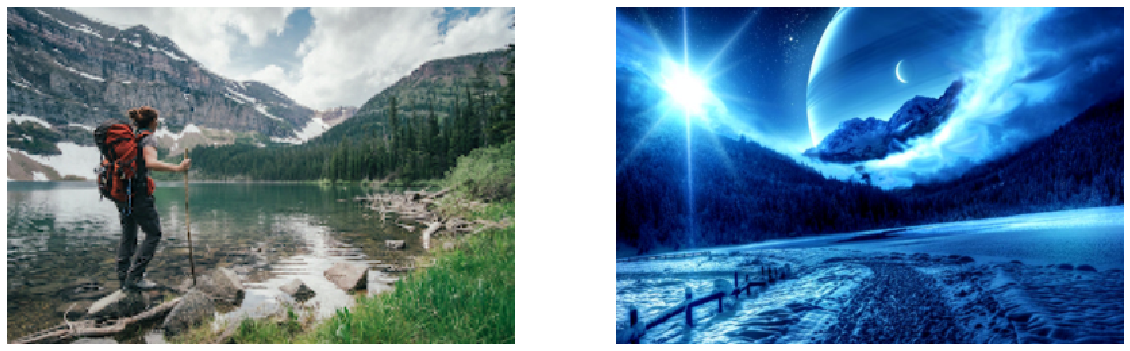

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# content and style ims side-by-side

ax1.imshow(img_convert(Content_img))
ax1.axis('off')
ax2.imshow(img_convert(Style_img))
ax2.axis('off')
plt.show()

## Content & Style Features

Below, complete the mapping of layer names to the names found in the paper for the content representation and the style representation.

In [9]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    # Layers needed for the content and style representations of an image
    if layers is None:
        layers = {'0' : 'conv1_1',
                  '5' : 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
    features = {} # Dictionary that stores the features extracted from the required layers
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        if name in layers:
            x = layer(x) # Output of the image through the corresponding layer
            features[layers[name]] = x
            
    return features

## Gram Matrix

<div align='center'>The normal method to calculate the <i>Gram Matrix</i> is show below but here we shall use a vcectorized implementation of the <i>Gram Matrix</i> which is calculated by multiplying the reshaped tensor by it's transpose.
Here the tensors are reshaped so that the spatial dimensions are flattened</div>

![gram](./images/Gram.png)



In [10]:
def Gram_matrix(tensor):
    
    # Get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    # Reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # Calculate the gram matrix
    Gram = torch.mm(tensor, tensor.t())
    
    return Gram

In [15]:
# get content and style features only once before training
content_features = get_features(Content_img, VGG)
style_features = get_features(Style_img, VGG)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: Gram_matrix(style_features[layer]) for layer in style_features}

# Its better to start off with the target as a copy of the content image
target = Content_img.clone().requires_grad_(True).to(device)

In [16]:
# Weights for each style layer 
# Weighting earlier layers more will result in larger style artifacts
# We are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.65,
                 'conv3_1': 0.2,
                 'conv4_1': 0.25,
                 'conv5_1': 0.30}

content_weight = 1  # alpha
style_weight = 1e6  # beta

## Style Transfer

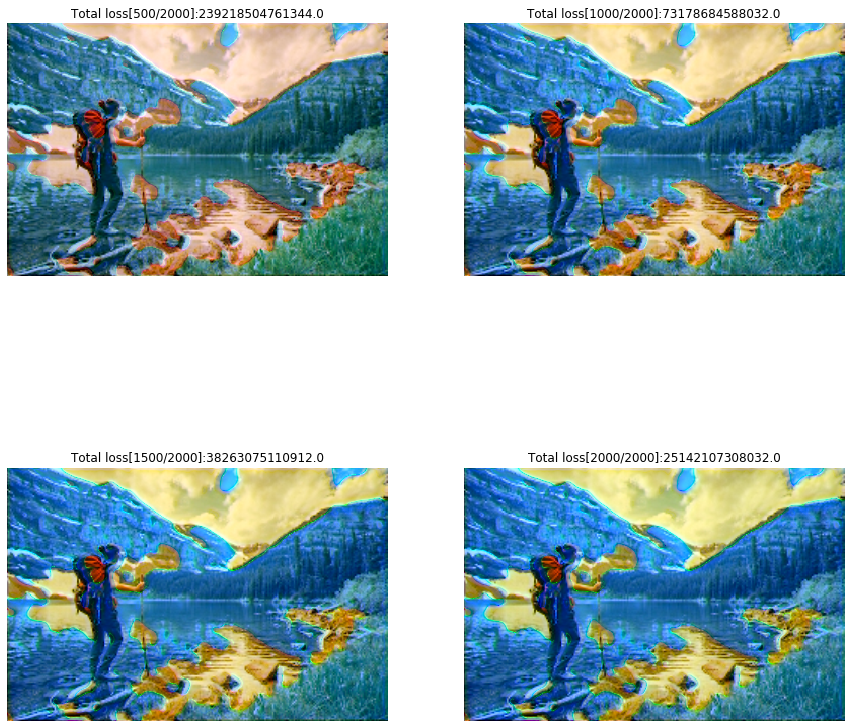

In [18]:
show_every = 500 

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
""" Always take the (epochs/show_every)as a multiple
    of two for diplaying the output images in a grid """
epochs = 2000  # No of iterations

grid_Size = (epochs/show_every)
fig, ax = plt.subplots(2, int(grid_Size/2),figsize=(15,15))
i=0
j=0

for ii in range(1, epochs+1):
    
    # Get the features from your target image
    target_features = get_features(target, VGG)
    
    # Content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # Style loss
    style_loss = 0
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = Gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # To display intermediate images and their loss
    if((ii % show_every) == 0):
        idx = ii/show_every
        if(idx<=(int(grid_Size/2))):
            ax[i,j].imshow(img_convert(target))
            ax[i,j].axis('off')
            ax[i,j].set_title("Total loss[{}/{}]:{}".format(ii,epochs,total_loss.item()))
            if(idx<int(grid_Size/2)):
                j+=1
            else:
                i=1
                j=0
        else:
            ax[i,j].imshow(img_convert(target))
            ax[i,j].axis('off')
            ax[i,j].set_title("Total loss[{}/{}]:{}".format(ii,epochs,total_loss.item()))
            if(idx<grid_Size):
                j+=1

## Display The Final Result

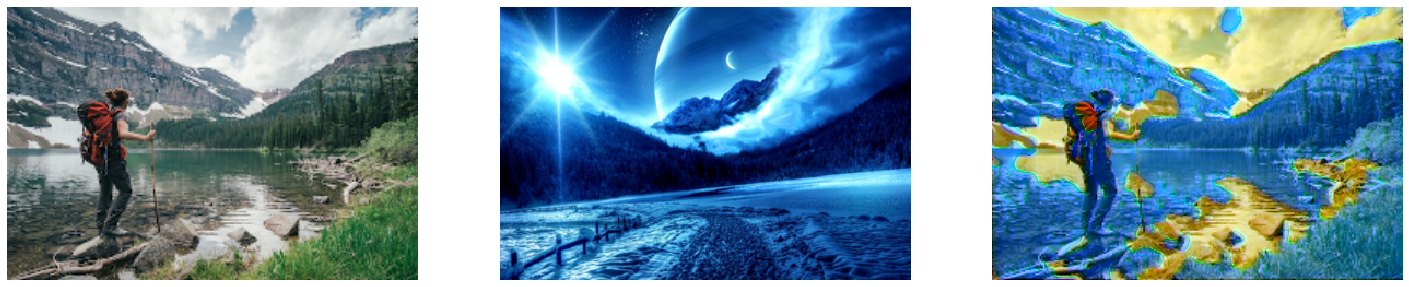

In [20]:
# display the images
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 10))
# content and style ims side-by-side
ax1.imshow(img_convert(Content_img))
ax1.axis('off')
ax2.imshow(img_convert(Style_img))
ax2.axis('off')
ax3.imshow(img_convert(target))
ax3.axis('off')
plt.show()